## Imports

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, classification_report, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, train_test_split, ValidationCurveDisplay, validation_curve

dir_parts = os.getcwd().split(os.path.sep)
root_index = dir_parts.index('ML-B-main')
root_path = os.path.sep.join(dir_parts[:root_index + 1])
sys.path.append(root_path + '/code/')
from data.data_config import Dataset
from data.data_utils import load_monk, load_cup, store_monk_result, store_cup_result
from hyperparameter_tuning import grid_search_top_configs
from training.metrics import mean_euclidean_error

%load_ext autoreload
%autoreload 2

# K-NN
In this notebook we test a **KNeighborsClassifier** and a **KNeighborsRegressor** w.r.t. the tasks at hand, i.e. the three MONK's problems and the CUP dataset respectively.

In [2]:
MODEL_NAME = 'K-NN'

## Path

In [3]:
# Directories
results_dir = root_path + '/results/' + MODEL_NAME

# Filepaths (MONK)
m1_dev_path, m1_test_path = Dataset.MONK_1.dev_path, Dataset.MONK_1.test_path # MONK 1
m2_dev_path, m2_test_path = Dataset.MONK_2.dev_path, Dataset.MONK_2.test_path # MONK 2
m3_dev_path, m3_test_path = Dataset.MONK_3.dev_path, Dataset.MONK_3.test_path # MONK 3

# Filepaths (CUP)
cup_dev_path, cup_test_path = Dataset.CUP.dev_path, Dataset.CUP.test_path

# MONK-1

In [4]:
# Load MONK-1
x_dev_m1, y_dev_m1, x_test_m1, y_test_m1 = load_monk(m1_dev_path, m1_test_path)

First of all, we define the grid search spaces for the SVC that we're going to use for all three MONK's problems.

In [27]:
# hparams grid for grid search
clf_hparams_spaces = {'n_neighbors': list(range(2,int(len(x_dev_m1)/2))),
                      'weights': ['uniform', 'distance'],
                      'p': [1,2]
                     }

## Grid search
Grid search is a simple hyper-parameter tuning techniques useful for finding the best configuration for a specific ML model. It involves:
- defining a grid of hparams values
- systematically test all possible combinations


In [28]:
# perform grid search with KFold

grid_search_m1 = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=clf_hparams_spaces,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=128),
    scoring='accuracy',
    verbose=1
)

grid_search_m1.fit(x_dev_m1, y_dev_m1)


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [29]:
best_configs_m1, candidates_m1 = grid_search_top_configs(grid_search_m1.cv_results_) # top k config

Model rank 1 - Config: {'n_neighbors': 22, 'p': 1, 'weights': 'distance'}
Mean score 0.8223 - Std score: 0.0218

Model rank 2 - Config: {'n_neighbors': 24, 'p': 1, 'weights': 'distance'}
Mean score 0.8223 - Std score: 0.0218

Model rank 3 - Config: {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
Mean score 0.8147 - Std score: 0.0311

Model rank 4 - Config: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Mean score 0.8147 - Std score: 0.0401

Model rank 5 - Config: {'n_neighbors': 8, 'p': 2, 'weights': 'distance'}
Mean score 0.8067 - Std score: 0.0382



In [31]:
# Create a SVC with the best hparams
clf = KNeighborsClassifier(**grid_search_m1.best_params_)
#clf = KNeighborsClassifier(**grid_search_cup.cv_results_['params'][candidates_m1[2]]) #Uses different model rank (candidates[1] = best_params_)

# Train the model
clf.fit(x_dev_m1, y_dev_m1)


KNeighborsClassifier(n_neighbors=22, p=1, weights='distance')

In [32]:
print('-- DEVELOPMENT --')
print(classification_report(y_dev_m1, clf.predict(x_dev_m1)))
accuracy_dev_m1 = accuracy_score(y_dev_m1, clf.predict(x_dev_m1))
mse_dev_m1 = mean_squared_error(y_dev_m1, clf.predict(x_dev_m1))
print(f"Accuracy_dev = {accuracy_dev_m1:.2f}")
print(f"MSE_dev = {mse_dev_m1:.4f}")

-- DEVELOPMENT --
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        62

    accuracy                           1.00       124
   macro avg       1.00      1.00      1.00       124
weighted avg       1.00      1.00      1.00       124

Accuracy_dev = 1.00
MSE_dev = 0.0000


- **Precision** is the ability of the classifier not to label as positive a sample that is negative:
=> Precision = True Positive / (True Positive + False Positive)

- **Recall** (or sensitivity) is the ability of the classifier to find all the positive samples:
=> Recall = True Positive / (True Positive + False Negative)

**Precision VS Recall**
- Use precision when the cost of false positives is high: In situations where misclassifying an instance as positive has serious consequences, precision is a better choice. For example, in medical diagnosis.
- Use recall when the cost of false negatives is high: When the consequence of misclassifying an instance as negative is severe, recall is a better choice. For example, in fraud detection.

The **F1 score** is the harmonic mean of the precision and recall. It thus symmetrically represents both precision and recall in one metric (F1 score gives equal importance to precision and recall)
=> F1 = (Precision * Recall) / (Precision + Recall)

In [33]:
print('-- TEST --')
report_test_m1 = classification_report(y_test_m1, clf.predict(x_test_m1))
print(report_test_m1)
accuracy_test_m1 = accuracy_score(y_test_m1, clf.predict(x_test_m1))
mse_test_m1 = mean_squared_error(y_test_m1, clf.predict(x_test_m1))
print(f"Accuracy_test = {accuracy_test_m1:.2f}")
print(f"MSE_test = {mse_test_m1:.4f}")

-- TEST --
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       216
           1       0.84      0.81      0.82       216

    accuracy                           0.83       432
   macro avg       0.83      0.83      0.83       432
weighted avg       0.83      0.83      0.83       432

Accuracy_test = 0.83
MSE_test = 0.1713


## Store results

In [34]:
store_monk_result(results_dir + '/MONK1/', best_configs_m1, report_test_m1)

# MONK-2

In [35]:
# Load MONK-2
x_dev_m2, y_dev_m2, x_test_m2, y_test_m2 = load_monk(m2_dev_path, m2_test_path)

In [36]:
# perform grid search with KFold
grid_search_m2 = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=clf_hparams_spaces,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=128),
    scoring='accuracy',
    verbose=1
)

grid_search_m2.fit(x_dev_m2, y_dev_m2)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [37]:
best_configs_m2, candidates_m2 = grid_search_top_configs(grid_search_m2.cv_results_) # top k config

Model rank 1 - Config: {'n_neighbors': 56, 'p': 1, 'weights': 'distance'}
Mean score 0.6392 - Std score: 0.0266

Model rank 2 - Config: {'n_neighbors': 57, 'p': 1, 'weights': 'distance'}
Mean score 0.6392 - Std score: 0.0266

Model rank 3 - Config: {'n_neighbors': 59, 'p': 1, 'weights': 'distance'}
Mean score 0.6392 - Std score: 0.0266

Model rank 4 - Config: {'n_neighbors': 58, 'p': 1, 'weights': 'distance'}
Mean score 0.6392 - Std score: 0.0266

Model rank 5 - Config: {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
Mean score 0.6390 - Std score: 0.0389



In [38]:
# Create a SVC with the best hparams
clf = KNeighborsClassifier(**grid_search_m2.best_params_)
#clf = KNeighborsClassifier(**grid_search_cup.cv_results_['params'][candidates_m2[2]])

# Train the model
clf.fit(x_dev_m2, y_dev_m2)

KNeighborsClassifier(n_neighbors=56, p=1, weights='distance')

In [39]:
print('-- DEVELOPMENT --')
print(classification_report(y_dev_m2, clf.predict(x_dev_m2)))
accuracy_dev_m2 = accuracy_score(y_dev_m2, clf.predict(x_dev_m2))
mse_dev_m2 = mean_squared_error(y_dev_m2, clf.predict(x_dev_m2))
print(f"Accuracy_dev = {accuracy_dev_m2:.2f}")
print(f"MSE_dev = {mse_dev_m2:.4f}")

-- DEVELOPMENT --
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00        64

    accuracy                           1.00       169
   macro avg       1.00      1.00      1.00       169
weighted avg       1.00      1.00      1.00       169

Accuracy_dev = 1.00
MSE_dev = 0.0000


In [40]:
print('-- TEST --')
report_test_m2 = classification_report(y_test_m2, clf.predict(x_test_m2))
print(report_test_m2)
accuracy_test_m2 = accuracy_score(y_test_m2, clf.predict(x_test_m2))
mse_test_m2 = mean_squared_error(y_test_m2, clf.predict(x_test_m2))
print(f"Accuracy_test = {accuracy_test_m2:.2f}")
print(f"MSE_test = {mse_test_m2:.4f}")

-- TEST --
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       290
           1       0.90      0.45      0.60       142

    accuracy                           0.80       432
   macro avg       0.84      0.71      0.74       432
weighted avg       0.82      0.80      0.78       432

Accuracy_test = 0.80
MSE_test = 0.1968


In [41]:
store_monk_result(results_dir + '/MONK2/', best_configs_m2, report_test_m2)

# MONK-3

In [42]:
# Load MONK-3
x_dev_m3, y_dev_m3, x_test_m3, y_test_m3 = load_monk(m3_dev_path, m3_test_path)

In [43]:
# perform grid search with KFold
grid_search_m3 = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=clf_hparams_spaces,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=128),
    scoring='accuracy',
    verbose=1
)

grid_search_m3.fit(x_dev_m3, y_dev_m3)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=128, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [44]:
best_configs_m3, candidates_m3 = grid_search_top_configs(grid_search_m3.cv_results_) # top k config

Model rank 1 - Config: {'n_neighbors': 43, 'p': 1, 'weights': 'distance'}
Mean score 0.9273 - Std score: 0.0584

Model rank 2 - Config: {'n_neighbors': 45, 'p': 1, 'weights': 'distance'}
Mean score 0.9190 - Std score: 0.0498

Model rank 3 - Config: {'n_neighbors': 44, 'p': 1, 'weights': 'distance'}
Mean score 0.9107 - Std score: 0.0459

Model rank 4 - Config: {'n_neighbors': 43, 'p': 2, 'weights': 'distance'}
Mean score 0.9107 - Std score: 0.0459

Model rank 5 - Config: {'n_neighbors': 47, 'p': 1, 'weights': 'distance'}
Mean score 0.9030 - Std score: 0.0777



In [45]:
# Create a SVC with the best hparams
clf = KNeighborsClassifier(**grid_search_m3.best_params_)
#clf = KNeighborsClassifier(**grid_search_cup.cv_results_['params'][candidates_m3[2]])

# Train the model
clf.fit(x_dev_m3, y_dev_m3)

KNeighborsClassifier(n_neighbors=43, p=1, weights='distance')

In [46]:
print('-- DEVELOPMENT --')
print(classification_report(y_dev_m3, clf.predict(x_dev_m3)))
accuracy_dev_m3 = accuracy_score(y_dev_m3, clf.predict(x_dev_m3))
mse_dev_m3 = mean_squared_error(y_dev_m3, clf.predict(x_dev_m3))
print(f"Accuracy_dev = {accuracy_dev_m3:.2f}")
print(f"MSE_dev = {mse_dev_m3:.4f}")

-- DEVELOPMENT --
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        60

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122

Accuracy_dev = 1.00
MSE_dev = 0.0000


In [47]:
print('-- TEST --')
report_test_m3 = classification_report(y_test_m3, clf.predict(x_test_m3))
print(report_test_m3)
accuracy_test_m3 = accuracy_score(y_test_m3, clf.predict(x_test_m3))
mse_test_m3 = mean_squared_error(y_test_m3, clf.predict(x_test_m3))
print(f"Accuracy_test = {accuracy_test_m3:.2f}")
print(f"MSE_test = {mse_test_m3:.4f}")

-- TEST --
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       204
           1       0.99      0.91      0.95       228

    accuracy                           0.95       432
   macro avg       0.95      0.95      0.95       432
weighted avg       0.95      0.95      0.95       432

Accuracy_test = 0.95
MSE_test = 0.0532


In [48]:
store_monk_result(results_dir + '/MONK3/', best_configs_m3, report_test_m3)

# CUP

In [49]:
# Load CUP
x_dev_cup, y_dev_cup, x_test_cup = load_cup(cup_dev_path, cup_test_path)

In [50]:
# Split data for internal test
x_train_cup, x_intest_cup, y_train_cup, y_intest_cup = train_test_split(x_dev_cup, y_dev_cup, test_size=0.2, random_state=128)

In [7]:
# SVR models can produce only one output, so the three columns of the output are separated
y_train_cup1, y_train_cup2, y_train_cup3 = np.hsplit(y_train_cup, 3)
y_intest_cup1, y_intest_cup2, y_intest_cup3 = np.hsplit(y_intest_cup, 3)
y_dev_cup1, y_dev_cup2, y_dev_cup3 = np.hsplit(y_dev_cup, 3)

# Targets must be of the form (n° samples, )
y_train_cup1 = np.ravel(y_train_cup1)
y_train_cup2 = np.ravel(y_train_cup2)
y_train_cup3 = np.ravel(y_train_cup3)
y_intest_cup1 = np.ravel(y_intest_cup1)
y_intest_cup2 = np.ravel(y_intest_cup2)
y_intest_cup3 = np.ravel(y_intest_cup3)
y_dev_cup1 = np.ravel(y_dev_cup1)
y_dev_cup2 = np.ravel(y_dev_cup2)
y_dev_cup3 = np.ravel(y_dev_cup3)

# Hyperparameters tuning
Here, we define the grid search spaces for the SVR for the CUP dataset.

In [65]:
# hparams grid for grid search
regr_hparams_spaces = {'n_neighbors': list(range(2,int(len(x_train_cup)/2))),
                      'weights': ['uniform', 'distance'],
                      'p': [1,2]
                     }

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1990 out of 1990 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1990 out of 1990 | elapsed:   17.8s finished


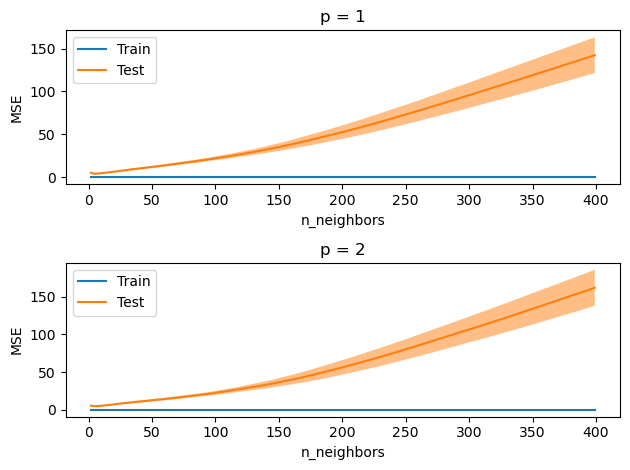

min_train_scores = [-0.0, -0.0]
min_test_scores = [-3.2201, -3.7102]


In [75]:
# Validation curves
param_name = "n_neighbors"
param_range = np.arange(2, int(len(x_train_cup)/2))
figure, axis = plt.subplots(2, 1)
min_train_scores=[]
min_test_scores=[]

for (p, i) in zip([1,2], [0,1]):
    train_scores, test_scores = validation_curve(KNeighborsRegressor(weights = 'distance', p = p), 
                                          x_train_cup, 
                                          y_train_cup, 
                                          param_name=param_name, 
                                          param_range=param_range,
                                          cv=KFold(n_splits=5, shuffle=True, random_state=128),
                                          scoring= 'neg_mean_squared_error',
                                          n_jobs=-1,
                                          verbose=1)
    
    min_train_scores.append(round(np.max(train_scores),4)) #score is negative
    min_test_scores.append(round(np.max(test_scores),4)) 
                                          
    display = ValidationCurveDisplay(param_name=param_name, 
                                     param_range=param_range,
                                     train_scores=train_scores, 
                                     test_scores=test_scores,
                                     score_name="MSE")
    display.plot(ax=axis[i], negate_score = True)
    axis[i].set_title('p = %d' %p)

figure.tight_layout()
plt.show()
print(f"min_train_scores = {min_train_scores}")
print(f"min_test_scores = {min_test_scores}")

## Grid search

In [66]:
# perform grid search with KFold
# Increased the cache to decrease the tarining time (from 200 to 1000 MB)
# Use n_jobs = number of jobs to run in parallel. -1 means using all processors
# scoring=make_scorer(mean_euclidean_error, greater_is_better=False)
grid_search_cup = GridSearchCV(
    KNeighborsRegressor(),
    param_grid=regr_hparams_spaces,
    cv=KFold(n_splits=5, shuffle=True, random_state=128),
    scoring= 'neg_mean_squared_error',
    verbose=1
)

grid_search_cup.fit(x_train_cup, y_train_cup)

Fitting 5 folds for each of 1592 candidates, totalling 7960 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=128, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error', verbose=1)

In [67]:
best_configs_cup, candidates = grid_search_top_configs(grid_search_cup.cv_results_) # top k config

Model rank 1 - Config: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Mean score -3.9000 - Std score: 0.3858

Model rank 2 - Config: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Mean score -3.9769 - Std score: 0.4465

Model rank 3 - Config: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Mean score -4.0445 - Std score: 0.4117

Model rank 4 - Config: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Mean score -4.2008 - Std score: 0.5302

Model rank 5 - Config: {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
Mean score -4.2819 - Std score: 0.5039



In [68]:
# Create a SVR with the best hparams
rfr = KNeighborsRegressor(**grid_search_cup.best_params_)
#rfr = KNeighborsRegressor(**grid_search_cup.cv_results_['params'][candidates[2]])

# Train the model
rfr.fit(x_train_cup, y_train_cup)

KNeighborsRegressor(p=1, weights='distance')

In [69]:
print('-- DEVELOPMENT --')
y_preds_up = rfr.predict(x_train_cup)
dev_mee_cup = mean_euclidean_error(y_train_cup, y_preds_up)
print(dev_mee_cup)

-- DEVELOPMENT --
0.0


In [70]:
print('--INTERNAL TEST --')
y_inpreds_up = rfr.predict(x_intest_cup)
intest_mee_cup = mean_euclidean_error(y_intest_cup, y_inpreds_up)
print(intest_mee_cup)

--INTERNAL TEST --
2.650346266135555


In [71]:
print('-- RETRAINING --')
rfr.fit(x_dev_cup, y_dev_cup)
y_preds_up = rfr.predict(x_dev_cup)
dev_mee_cup = mean_euclidean_error(y_dev_cup, y_preds_up)
print(dev_mee_cup)

-- RETRAINING --
0.0


In [72]:
# Blind test set predictions
test_preds_cup = rfr.predict(x_test_cup)

## Store Result

In [73]:
store_cup_result(results_dir + '/CUP/', best_configs_cup, 1, dev_mee_cup, intest_mee_cup, test_preds_cup)